# Construirea unui model matematic de regresie liniara multivariata

`M`achine `L`earning, `A`rtificial `I`nteligence

## 1. Importuri necesare, setari

In [1]:
# required imports
import gzip
import json
import os
import re

# multi-array stuff
import pandas as pd
import numpy as np

# plot stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sea

# import and set no warnigns
import warnings
warnings.filterwarnings('ignore')

# set pd max cols / rows = 999
# pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999

## 2. Incarcare, parsare, modelare date AUTOVIT.RO

In [2]:
def strip_nr(str_nr):
    if str_nr is not None:
        return int(re.sub(r'[^0-9]+', '', str_nr))
    else:
        raise TypeError
    
def get_listing_param(data, name):
    for p in data['listing_params']:
        if p[0] == name:
            return p[1]
    else:
        return None

def get_data():
    raw_adverts = []
    for root, dirs, files in os.walk('../database/autovit/adverts/'):
        for name in files:
            file = os.path.join(root, name)
            with gzip.open(file, 'r') as fin:
                raw_adverts.extend(json.loads(fin.read().decode('utf-8')))
    print('** Total loaded adverts: {} **'.format(len(raw_adverts)))
    raw_adverts[0].pop('photos', None)
    return raw_adverts

def parse_data(raw_adverts):
    parsed_adverts = []
    for ad in raw_adverts:
        # Ad has req data, essential
        if 'list_label' in ad \
            and get_listing_param(ad, 'Anul fabricatiei') is not None \
            and get_listing_param(ad, 'Kilometraj') is not None \
            and get_listing_param(ad, 'Combustibil') is not None \
            and 'features' in ad \
            and 'params' in ad:

            # reshape params data
            if 'params' in ad:
                for p in ad['params']:
                    ad[p[0]] = p[1]
                # pop extra params
                ad.pop('params', None)

            # reshape features
            if 'features' in ad:
                for f in ad['features']:
                    ad[f] = True
                # pop extra features
                ad.pop('features', None)

            # format price as int only
            if 'list_label' in ad:
                ad['price'] = strip_nr(ad['list_label'])
                ad.pop('list_label', None)
            else:
                print('No list label')

            ad['fabrication_year'] = strip_nr(get_listing_param(ad, 'Anul fabricatiei'))
            ad['kilometers'] = strip_nr(get_listing_param(ad, 'Kilometraj'))
            ad['fuel'] = get_listing_param(ad, 'Combustibil').lower()
            ad['brand_model'] = '{}-{}'.format(ad['Marca'], ad['Model'])

            # Params
            hp = ad['Putere'] if 'Putere' in ad else None
            if hp is not None:
                hp = strip_nr(hp.replace('CP', ''))
                ad['horse_power'] = hp

            co2 = ad['Emisii CO2'] if 'Emisii CO2' in ad else None
            if co2 is not None:
                co2 = strip_nr(co2.replace('g/km', ''))
                ad['emissions'] = co2

            # Listing params
            cc = get_listing_param(ad, 'Capacitate cilindrica')
            if cc is not None:
                cc = strip_nr(cc.replace('cm3', ''))
                ad['cubic_capacity'] = cc

            # pop unused keys
            ad.pop('photos', None)
            ad.pop('description', None)

            # append to list
            parsed_adverts.append(ad)

    return parsed_adverts


adverts = parse_data(get_data())
print('** Parsed usable adverts: {} **'.format(len(adverts)))

** Total loaded adverts: 8306 **
** Parsed usable adverts: 7076 **


### Informatii despre dataset
`count`, `mean`, `min`, `max`, `std = standard deviation`

In [3]:
df = pd.DataFrame(adverts)
df.describe()

,age,highlighted,urgent,topAd,category_id,business,hide_user_ads_button,dealer_logo_in_results,dealer_logo_in_ad_page,has_phone,has_email,map_radius,map_private_radius_size,ad_featured,price,fabrication_year,kilometers,horse_power,cubic_capacity,emissions
count,7076.000000,7076.0,7076.0,7076.000000,7076.0,7076.000000,7076.0,7076.000000,7076.000000,7041.0,7076.0,7076.000000,7076.0,7076.0,7076.000000,7076.000000,7.076000e+03,6971.000000,6930.000000,4300.000000
mean,72.856416,0.0,0.0,0.029112,29.0,0.526286,0.0,0.405879,0.444460,1.0,1.0,0.044941,2.0,0.0,17453.285331,2013.341012,1.483653e+05,162.811218,1979.163348,140.655581
std,161.639753,0.0,0.0,0.168134,0.0,0.499344,0.0,0.491096,0.496941,0.0,0.0,0.207188,0.0,0.0,24438.151689,4.861911,9.915995e+04,77.720817,608.129025,42.736634
min,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,450.000000,1982.000000,1.000000e+00,2.000000,599.000000,1.000000
25%,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,5600.000000,2010.000000,7.808325e+04,110.000000,1598.000000,114.000000
50%,28.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,9999.000000,2014.000000,1.574355e+05,147.000000,1968.000000,135.000000
75%,69.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.000000,2.0,0.0,19950.000000,2017.000000,2.110000e+05,190.000000,2000.000000,159.000000
max,4039.000000,0.0,0.0,1.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,1.000000,2.0,0.0,839496.000000,2021.000000,2.690000e+06,780.000000,6749.000000,1329.000000


### Randurile si coloanele datasetului

In [4]:
df.head(5)

,id,region_id,region_name,city_id,city_name,district_id,district_name,new_used,url,preview_url,...,brand_program_id,brand_program_small_logo,Avariata,Volan pe dreapta,,Predare leasing,Plata initiala (la predare),Valoare rata lunara,Numar de rate lunare ramase,Valoare reziduala
0,7043759122,13,Timis,97411,Remetea Mare,,,used,https://www.autovit.ro/anunt/audi-a6-ID7GGTv6....,https://www.autovit.ro/i2/anunt/audi-a6-ID7GGT...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7044506685,42,Teleorman,69925,Videle,,,used,https://www.autovit.ro/anunt/audi-a4-ID7GK1Zz....,https://www.autovit.ro/i2/anunt/audi-a4-ID7GK1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7044051670,35,Dambovita,63351,Targoviste,,,used,https://www.autovit.ro/anunt/audi-a4-2-0-ID7GI...,https://www.autovit.ro/i2/anunt/audi-a4-2-0-ID...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7044056336,12,Sibiu,34907,Talmaciu,,,used,https://www.autovit.ro/anunt/volkswagen-caddy-...,https://www.autovit.ro/i2/anunt/volkswagen-cad...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7044521035,34,Valcea,89649,Ramnicu Valcea,,,used,https://www.autovit.ro/anunt/opel-corsa-1-3-ID...,https://www.autovit.ro/i2/anunt/opel-corsa-1-3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Stergerea anomaliilor

In [5]:
def remove_outliers(x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3 - Q1 # IQR is interquartile range. 
    filter = (df[x] >= Q1 - 1.5 * IQR) & (df[x] <= Q3 + 1.5 * IQR)
    return df.loc[filter]  

df = remove_outliers('price')
df = remove_outliers('kilometers')
df = remove_outliers('fabrication_year')
df = remove_outliers('cubic_capacity')
df = remove_outliers('horse_power')
df = remove_outliers('emissions')

## 3. Ipoteza in urma cercetarii statisticilor

### Parametrii semnificativi (analiza vizuala):

- [x] price
- [x] ```'{}_{}'.format(brand, model)```
- [x] fuel 
- [x] body
- [x] kilometers (coef. negativ, relatie inversa)
- [x] horse_power
- [x] fabrication_year

## 4. Construirea unui sub-dataset

Pentru `dataset`-ul acestui model sunt folosite doar 3 caracteristici de antrenare, si 1 caracteristica pentru prezicere

```py
# Example
X['kilometers', 'horse_power', 'fabrication_year'] # train set
y['price'] # predict set
```

In [6]:
dtype = [
    'price', 
    'kilometers',  
    'horse_power', 
    'fabrication_year', 
]

df_model = df[dtype]
df_model.head()

,price,kilometers,horse_power,fabrication_year
1,8950,298350,143.0,2011
2,9599,206000,143.0,2013
3,9500,139795,140.0,2013
5,4500,241000,92.0,2011
6,21000,235000,184.0,2014


## 5. Conversia datelor categorice in date ordinare

In [7]:
# Defining the map function
def dummies(x):
    temp = pd.get_dummies(df_model[x], drop_first = True)
    df_dummies = pd.concat([df_model, temp], axis = 1)
    df_dummies.drop([x], axis = 1, inplace = True)
    return df_dummies

# Not the case for the training selected datase
# df_model = dummies('Marca')

# TODO: copy for model 5
# df_model = dummies('brand_model')
# df_model = dummies('fuel')
# df_model = dummies('Caroserie')
# df_model = dummies('emissions')

df_model.head()

,price,kilometers,horse_power,fabrication_year
1,8950,298350,143.0,2011
2,9599,206000,143.0,2013
3,9500,139795,140.0,2013
5,4500,241000,92.0,2011
6,21000,235000,184.0,2014


### Forma dataset-ului

In [8]:
df_model.shape

(3476, 4)

## 6. Impartirea dataset-ului in doua dataset-uri

```py
df_train = 0.8 * df # used to train the model
df_test  = 0.2 * df # used to test the model
```

In [9]:
from sklearn.model_selection import train_test_split

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


# clean of NaN, inf, -inf
df_model = clean_dataset(df_model)
np.random.seed(0)

# split data 
df_train, df_test = train_test_split(df_model, train_size = 0.8, test_size = 0.2, random_state = 100)

## 7. Scalarea / uniformizarea datelor (0.0 - 1.0)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train[dtype] = scaler.fit_transform(df_train[dtype])

In [11]:
df_train.describe()

,price,kilometers,horse_power,fabrication_year
count,2780.000000,2780.000000,2780.000000,2780.000000
mean,0.260491,0.410318,0.443395,0.677893
std,0.198511,0.211042,0.194687,0.184691
min,0.000000,0.000000,0.000000,0.000000
25%,0.119745,0.264621,0.289474,0.541667
50%,0.200430,0.438501,0.452632,0.708333
75%,0.349836,0.561496,0.580263,0.833333
max,1.000000,1.000000,1.000000,1.000000


### Intercorelarea parametriilor

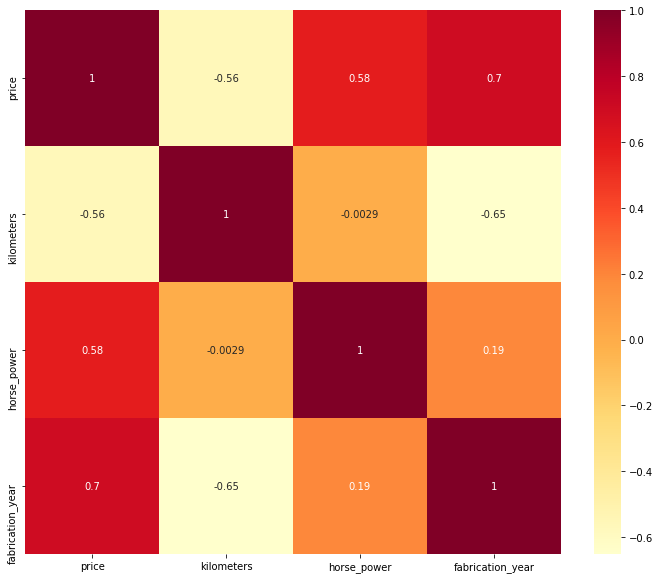

In [12]:
plt.figure(figsize = (12, 10))
sea.heatmap(df_train.corr(), annot = True, cmap="YlOrRd")
plt.show()

## 8. Impartirea datasetului df_train in X, y

In [13]:
# X = columns to form ecuation 
X_train = df_train
# y = column 'price', to form eq_res == y
y_train = df_train.pop('price')

if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
    raise Exception

X_train.head()

,kilometers,horse_power,fabrication_year
6072,0.339001,0.342105,0.416667
216,0.504009,0.526316,0.791667
508,0.489303,0.257895,0.750000
5271,0.546881,0.263158,0.166667
1127,0.542780,0.342105,0.625000


## 9. Crearea modelului de regresie liniara si eliminarea caracteristicilor recursive

 `RFE` =  Recursive Feature Elimination, is a feature selection algorithm.  

> Feature selection refers to techniques that select a subset of the most relevant features (columns) for a dataset.  
> Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective

In [14]:
# Recursive feature elimination
# Pruning low correlation coef. features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10, verbose=1)
rfe = rfe.fit(X_train, y_train)

In [15]:
# Show list with supported features and ranking
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('kilometers', True, 1),
 ('horse_power', True, 1),
 ('fabrication_year', True, 1)]

In [16]:
X_train.columns[rfe.support_]

Index(['kilometers', 'horse_power', 'fabrication_year'], dtype='object')

### X_train_rfe = datasetul nou

In [17]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,kilometers,horse_power,fabrication_year
6072,0.339001,0.342105,0.416667
216,0.504009,0.526316,0.791667
508,0.489303,0.257895,0.750000
5271,0.546881,0.263158,0.166667
1127,0.542780,0.342105,0.625000


## 10. Calcularea efectiva a modelului de Regresie Liniara cu datasetul X_train_rfe

In [18]:
def build_model(X, y):
    X = sm.add_constant(X) # adding the constant col of 1 1 1 1 1
    lm = sm.OLS(y, X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X

In [19]:
X_train_new = build_model(X_train_rfe, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     2695.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:59:06   Log-Likelihood:                 2446.9
No. Observations:                2780   AIC:                            -4886.
Df Residuals:                    2776   BIC:                            -4862.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1523      0.013  

##### Parametri cu o valoare Prob (F-statistic) > 0.05 (alfa) trebuie eliminati

> The significance level α (alfa) is the probability of making the wrong decision when the null hypothesis is true. 

In [20]:
# X_train_new = X_train_new.drop(['cubic_centimeters'], axis = 1)
# X_train_new = build_model(X_train_new, y_train)

## 11. Calculul factorului de inflatie a variatiei

`VIF` = Variance Inflation Factor, for one exogenous variable.

> The variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable, given by exog_idx is added to the linear regression.  
> It is a measure for multicollinearity of the design matrix, exog.  
> 
> One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables.  
> The parameter estimates will have large standard errors because of this.

In [21]:
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

checkVIF(X_train)

,Features,VIF
1,horse_power,6.54
2,fabrication_year,5.64
0,kilometers,3.06


### Deleting > 5 values

In [22]:
# X_train_new = X_train_new.drop(['horse_power'], axis = 1)
# X_train_new = build_model(X_train_new, y_train)

# checkVIF(X_train_new)

## 12. Analiza distributiei erorilor, y_train vs y_train_predict

Se analizeaza erorile intre pretul estimat din `y_train_predict` vs pretul real din `y_train`

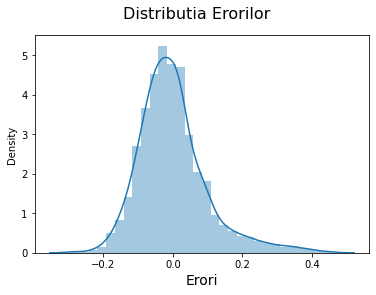

In [23]:
lm = sm.OLS(y_train, X_train_new).fit()
y_train_predict = lm.predict(X_train_new)

# Plot the histogram of the error terms
fig = plt.figure()
sea.distplot((y_train - y_train_predict), bins = 30)
fig.suptitle('Distributia Erorilor', fontsize = 16)
plt.xlabel('Erori', fontsize = 14)
plt.show()

Termenii de eroare par a fii aproximativ normal distribuiti, ipoteza unui model liniar se adevereste.

## 13. Preziceri pe datasetul df_test

In [24]:
# Scaling the test set
df_test[dtype] = scaler.fit_transform(df_test[dtype])

In [25]:
# Dividing into X and y
X_test = df_test
y_test = df_test.copy().pop('price')

In [26]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const', axis=1)

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [27]:
# Making predictions
y_pred = lm.predict(X_test_new)

## 14. Evaluarea modelului

### R^2, coeficientul de determinare

`R^2` = (coefficient of determination) regression score function

>Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).   
> 
>A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [28]:
from sklearn.metrics import r2_score 
r2 = r2_score(y_test, y_pred)

print('r^2 = {}'.format(r2))

r^2 = 0.7101725753632786


### Reprentarea grafica y_test vs y_pred

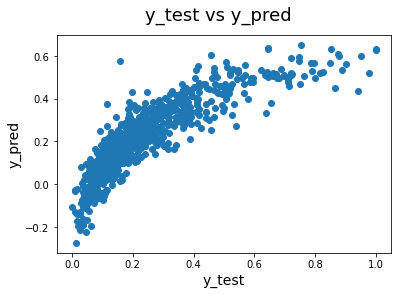

In [29]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=18)
plt.xlabel('y_test', fontsize=14)
plt.ylabel('y_pred', fontsize=14)
plt.show()

### Descrierea modelului

In [30]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     2695.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:59:06   Log-Likelihood:                 2446.9
No. Observations:                2780   AIC:                            -4886.
Df Residuals:                    2776   BIC:                            -4862.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1523      0.013  

In [31]:
print('R-squred and Adjusted R-squared ~= {}'.format(r2))

R-squred and Adjusted R-squared ~= 0.7101725753632786


F-statistic > 2500  
Prob(F-statistic) (overall model fit) == 0

> The F statistic must be used in combination with the p value when you are deciding if your overall results are significant. Why? If you have a significant result, it doesn’t mean that all your variables are significant. The statistic is just comparing the joint effect of all the variables together.
>
> 1. If the p value is less than the alpha level, go to Step 2 (otherwise your results are not significant and you cannot reject the null hypothesis). A common alpha level for tests is 0.05.
>
> 2. Study the individual p values to find out which of the individual variables are statistically significant.